<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Related-Research" data-toc-modified-id="Related-Research-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Related Research</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Has-the-variation-in-the-empirical-storm-season-changed-over-time?" data-toc-modified-id="Has-the-variation-in-the-empirical-storm-season-changed-over-time?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Has the variation in the empirical storm season changed over time?</a></span><ul class="toc-item"><li><span><a href="#State-Space-Model" data-toc-modified-id="State-Space-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>State Space Model</a></span></li></ul></li><li><span><a href="#Annual-Percentage-of-Storms-Outside-Official-Storm-Season-Changing?" data-toc-modified-id="Annual-Percentage-of-Storms-Outside-Official-Storm-Season-Changing?-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Annual Percentage of Storms Outside Official Storm Season Changing?</a></span></li><li><span><a href="#Is-the-Distribution-of-the-Empirical-Storm-Season-Stationary?" data-toc-modified-id="Is-the-Distribution-of-the-Empirical-Storm-Season-Stationary?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Is the Distribution of the Empirical Storm Season Stationary?</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Acknowledgments" data-toc-modified-id="Acknowledgments-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Acknowledgments</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction

This blog post attempts an analysis of the annual variability of dates on which storms occur.  Throughout, the word storm will refer generally to hurricanes or tropical cyclones in either the Atlantic or the Pacific oceans.  The inspiration of this analysis came from a [CSU, Chico](http://www.csuchico.edu/) campus seminar.

During the Fall semester of 2017, CSU, Chico's [Dr. Ann Bykerk-Kauffman](http://www.csuchico.edu/%7eabykerk-kauffman/) gave one of three talks at the [Department of Geological and Environmental Sciences](http://www.csuchico.edu/geos/index.shtml) seminar titled [2017 Hurricane Talk](http://www.csuchico.edu/geos/stories/17.09.14_HurricaneTalk.shtml).  Part of Dr. Bykerk-Kauffman's presentation included data from the National Oceanic and Atmospheric Administration's National Hurricane Center's (NHC) Data Archive: https://www.nhc.noaa.gov/data/#hurdat.  After her talk, Dr. David M. Hassenzahl, Dean of the [College of Natural Sciences](https://www.csuchico.edu/nsci/index.shtml), asked a great question, which I'll try to paraphrase:  Is the variation of the empirical storm season changing over time?

One possible way to interpret the phrase *variation of the empirical storm season* goes like this.  The [official storm season](https://en.wikipedia.org/wiki/Atlantic_hurricane_season) is June 01 to November 30.  This definition proves useful to contrast an empirical storm season.  The word empirical refers to the actual dates for which the multiple storms in any given year occur.  Just because we define a storm season, does not mean all the storms fall within the official storm season.  Some years contain some storms outside the official storm season, and some years contain all storms witihin the official storm season -- as we'll see later, no year in our data set has all storms outside of the official storm season.  Since there is not a direct correspondence between the official storm season and the empirical storm season, it's useful to separate these two phrases.  Last, the word variation describes the average variability in the length (measured in days) of the empirical storm season.

There are of course other ways to measure the variation of the empirical storm season.  This blog post attempts to quantify the annual variation of the empirical storm season in three different ways.  The first attempt follows the logic in the last paragraph.  The second attempt defines a proportion of storms that occur outside of the official storm season, relative to the total number of storms in each year.  The last attempt hypothesizes a probability distribution that produces storms throughout the year, and then asks if this distribution of storms changes over time.

# Related Research

XXX some words about
https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2008GL036012

https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0888.1

# Data Preparation

We begin by setting up the working environment: loading [Python](https://www.python.org) and various packages common to Python's datascience community, including [Stan](http://mc-stan.org) the probabilistic programming language which we'll use to fit Bayesian  models.

The HURDAT2 data used here was processed from the NHC data archive to enable this analysis.  The source code and data are available on [GitHub](https://github.com/roualdes/stormevents).

In [3]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import bplot as bp
import datetime
import pystan
import stan_utility
import requests
%matplotlib inline

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/roualdes/stormevents/master/data.csv')

To properly work with dates in Python, we convert dates, from the format YYYMMDD, into formal datetime objects.  We assign numbers to dates by counting days since 0001-01-01 UTC plus 1; see [matplotlib dates](https://matplotlib.org/api/dates_api.html) for technical details.   

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.drop_duplicates('name', inplace=True) # don't double count storms
df['year'] = df.date.dt.year 
df['month'] = df.date.dt.month
df['cnum_dates'] = mdates.date2num([datetime.datetime(2018, d.month, d.day)                     
                         for _, d in df['date'].dropna().iteritems()]) 
df['num_dates'] = mdates.date2num([datetime.datetime(d.year, d.month, d.day)                     
                         for _, d in df['date'].iteritems()])
df.head()

,date,time,record_identifier,intensity_rating,name,year,month,cnum_dates,num_dates
0,1851-06-25,0.0,NaN,HU,AL011851,1851,6,736870.0,675874.0
14,1851-07-05,1200.0,NaN,HU,AL021851,1851,7,736880.0,675884.0
15,1851-07-10,1200.0,NaN,TS,AL031851,1851,7,736885.0,675889.0
16,1851-08-16,0.0,NaN,TS,AL041851,1851,8,736922.0,675926.0
65,1851-09-13,0.0,NaN,TS,AL051851,1851,9,736950.0,675954.0


With dates properly set up, we can easily visualize the total number of storms each year.  The plot below shows that the number of storms occuring each year is increasing in time.

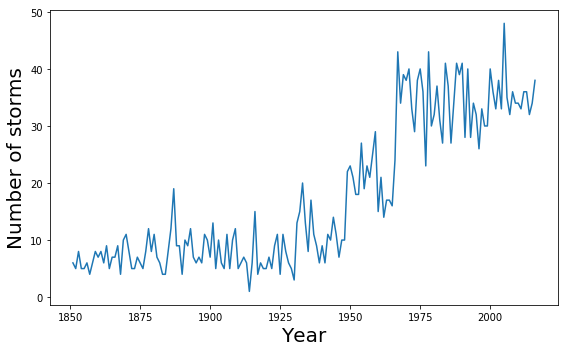

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(df['year'].unique(), 
         df['date'].dt.year.value_counts().sort_index())
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of storms', fontsize=20)
plt.tight_layout()

Or we can sum, within each month, the number storms that hit either the Pacific or Atlantic oceans.  September appears to be the most common month for a storm.

In [9]:
df['date'].dt.month.value_counts().sort_index()

1       5
2       1
3       2
4       5
5      77
6     253
7     406
8     697
9     841
10    485
11    114
12     16
Name: date, dtype: int64

Similar information is displayed with a histogram.  The histogram is nice because we can see how well the official storm season captures the highest density of storms.  Like above, the plot below is aggregated over all the years for which we have data.
<a id='average_density'></a>

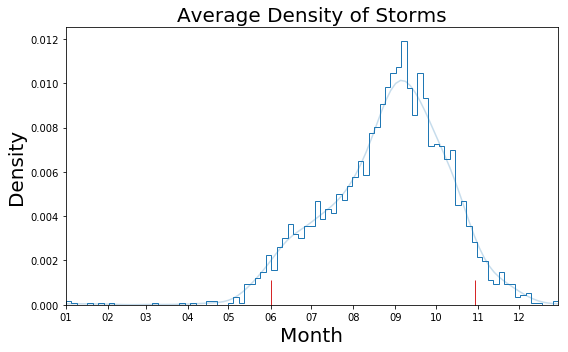

In [6]:
storm_season = mdates.date2num([datetime.datetime(2018, 6, 1), 
                                datetime.datetime(2018, 10, 30)])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()      
bp.histogram(df['cnum_dates'], bins=365//4)
bp.density(df['cnum_dates'], alpha=0.25) 
bp.rug(storm_season, markersize=50, color='tab:red')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Density', fontsize=20)      
plt.title('Average Density of Storms', fontsize=20)
ax.set_xlim([df['cnum_dates'].min(), df['cnum_dates'].max()])  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())                                 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))                          
plt.tight_layout()

# Has the variation in the empirical storm season changed over time?

In an effort to answer Dean Hassenzahl's question, we attempt to measure the variation of the empirical storm season year over year.  To measure such variation, we will use the [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD) statistic.  The MAD statistic is an estimator of the population standard deviation σ, which is based on the median instead of the mean making it more robust to potential outliers.  

To measure the variation of the emprical storm season over time, first consider a year $Y$.  In year $Y$, there will be a handful of storms that occur at different times.  Recall, we converted dates to numbers as per the discussion above in Section Data Preparation.  Define the median storm date as the date corresponding to the median of the numbers that represent the storms' dates.

The plot below depicts this visually for the year 2005.  The histogram of storms in 2005 appears in blue, as do the vertical ticks representing each storm.  The median storm date appears as the taller, red tick.
<a id='2005_density'></a>

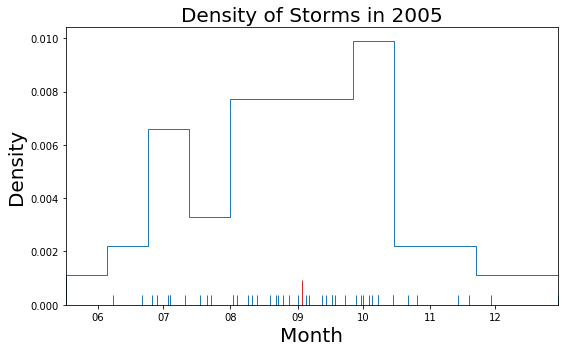

In [68]:
idx_2005 = df['year'] == 2005
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.histogram(df['num_dates'].loc[idx_2005], bins=365//30)
bp.rug(df['num_dates'].loc[idx_2005].values, markersize=20)
bp.rug(df['median'].loc[idx_2005].values[:1], markersize=50, color='tab:red')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Density', fontsize=20)      
plt.title('Density of Storms in 2005', fontsize=20)
ax.set_xlim([df['num_dates'].loc[idx_2005].min(), 
             df['num_dates'].loc[idx_2005].max()])  
ax.xaxis.set_major_locator(mdates.AutoDateLocator())                                 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m')) 
plt.tight_layout()

By this definition, across all the years, the median storm dates generaly fall in August or September.

In [7]:
df['median'] = df.groupby('year')['num_dates'].transform(lambda x: x.median())
df['median_date'] = mdates.num2date(df['median'])
df.drop_duplicates('year', inplace=False)['median_date'].dt.month.value_counts().sort_index()

7      1
8     72
9     90
10     3
Name: median_date, dtype: int64

The median storm date strictly measures an average storm date within year $Y$. Variation on the other hand measures average distance from the median storm date.  We measure distance from the median storm date in days.  Since some storms occur before the median storm date and some storms after, we take the absolute value of the distance of each storm from the median storm date. Our MAD estimator is the median of the absolute values of these distances.  The last step scales our MAD estimator by $\frac{1}{\Phi^{-1}(0.75)} \approx 1.4826$, in a fairly standard assumption of normal data.  In the end, we have MAD estimates of the variation of the empirical storm season for each year in our data set.

To help visualize this calculation, consider the plot above.  Count the days between each storm (blue ticks) and the median storm date (red tick) and disregard any potential negative signs.  From these counts, calculate the median and then scale it by $1.4826$.  This calcuation is done for each year, and we refer to the collection of yearly statistics as the MAD estimates.

In [8]:
df['mad'] = df.apply(lambda x: np.abs((x['num_dates'] - x['median'])), axis=1)
sdf = (df[['year', 'mad']].groupby('year', as_index=False)
            .aggregate(lambda x: 1.4826*np.median(x)))

A plot of the MAD estimates across time appears to show a subtle, positive slope.  A non-zero slope would indicate a change in the variation of the empirical storm season across time.  Hence, to answer Dean Hassenzahl's question, we seek to quantify statistically the slope of the following data.

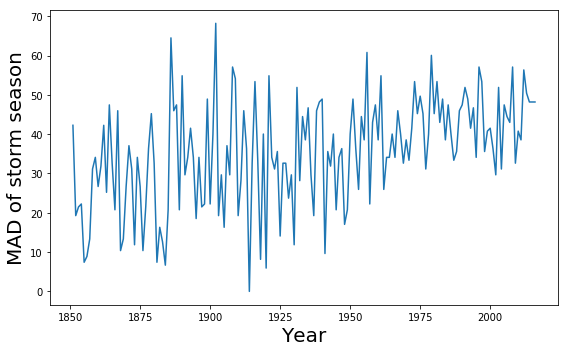

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'])
plt.xlabel('Year', fontsize=20)
plt.ylabel('MAD of storm season', fontsize=20)
plt.tight_layout()

A standard first statistical approach would be to fit ordinary least squares to these data.  However, fitting least squares to these data ignores all possible correlation in storm seasons across time.  Hence, each year is treated as independent.  Treating each year as independent is suspicious and can lead to over confident conclusions.  In an attempt at educational, we demonstrate this mistake below.

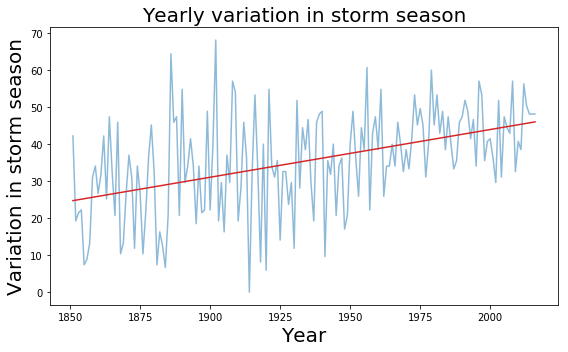

In [14]:
reg = sm.OLS(sdf['mad'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['mad'], alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues, color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

The regression output below suggests that the variation in empirical storm season is increasing over time.  Despite the small p-value on the year coefficient, I'm hesitant to admit that the storm season this year is not related to the storm season of next year in any way. 

In [15]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    mad   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     42.97
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           6.88e-10
Time:                        14:25:14   Log-Likelihood:                -649.14
No. Observations:                 166   AIC:                             1302.
Df Residuals:                     164   BIC:                             1309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -214.1017     38.073     -5.623      0.0

I present the regression output as a reminder that p-values are meaningless when an incorrect model is specified.  I also happen to believe that all models are incorrect, but this is not that place to discuss this matter.  We next improve upon this simplistic model.

## State Space Model

To better model these data, such that we do not strictly rule out a correlation of the storm seasons across time, we fit a Bayesian structural time series model using [Stan](http://mc-stan.org/).  Our model is a comparable to the local linear trend model, sometimes called the semilocal linear trend model

$$
\begin{align}
y_t & = \mu_t + \epsilon_t \\
\mu_{t+1} & = \mu_t + \nu_t + \gamma_t \\
\nu_{t+1} & = \eta + \phi(\nu_t - \eta) + \zeta_t \\ 
\epsilon_t & \sim \mathbb{N}(0, \sigma_y^2) \\
\gamma_t & \sim \mathbb{N}(0, \sigma_{\mu}^2) \\
\zeta_t & \sim \mathbb{N}(0, \sigma_{\nu}^2) \\
\end{align}
$$

where $y_t$ is the time series of interest and $\epsilon_t, \gamma_t$, and $\zeta_t$ are independent.  The variable $\eta$ is of most interest as it is a long run slope in the time series; the slope back towards which the deviations $\nu_{t}$ will drift.  For more details on this model, consult [Time Series Analysis by State Space Methods](https://www.amazon.com/Time-Analysis-State-Space-Methods/dp/019964117X/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=BXZQ1XM11ZFFZDP4QVSP) and [semilocal linear trend model](http://www.unofficialgoogledatascience.com/2017/07/fitting-bayesian-structural-time-series.html).

Here, the time series of interest $y_t$ is the yearly MAD estimates of variation of the empirical storm season. Since this model will better handle possible correlations across time in the MAD estimates of variation, we will have an appropriate estimate of the variation in the long run slope.

In Stan, we write this model as follows.

In [143]:
#local_linear = requests.get('https://raw.githubusercontent.com/roualdes/stormevents/master/local_linear.stan').text
with open('/Users/ez/stormevents/local_linear.stan') as ll:
    local_linear = ll.read()
print(local_linear)

data {
  int <lower=1> T;
  vector[T] y;
}
transformed data {
  real sd_y = sd(y);
}
parameters {
  real<lower=0> y_err;
  vector[T] u_err;
  vector[T] v_err;
  real eta;
  real<lower=-1, upper=1> phi;
}
transformed parameters {
  vector[T] u;
  vector[T] v;

  u[1] = y[1] + u_err[1];
  v[1] = v_err[1];
  for (t in 2:T) {
    u[t] = u[t-1] + v[t-1] + u_err[t-1];
    v[t] = eta + phi * (v[t-1] - eta) + v_err[t-1];
  }
}
model {
  // likelihood
  y ~ normal(u, y_err);

  // priors
  y_err ~ exponential(1 / sd_y);
  u_err ~ student_t(3, 0, 1);
  v_err ~ student_t(3, 0, 1);
  eta ~ student_t(3, 0, 1);
  phi ~ normal(0, 0.5);
}
generated quantities {
  vector[T] y_pred;
  for (t in 1:T)
    y_pred[t] = normal_rng(u[t], y_err);
}




In order to fit this model to the yearly variation in the storm season, we need to compile the above Stan program.

In [144]:
stmod = pystan.StanModel(model_code=local_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17927b24570aff9c495b5309f341a5ca NOW.


We run the compiled model below and then overlay the estimates from the local linear trend model on top of the yearly MAD estimates.

In [145]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': sdf['mad'].values.ravel()
}
stfit = stmod.sampling(data=sdata)                                                                                                                                    
posterior = stfit.extract()  

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Stan models, like many other sophisticated, statistical models, are susceptible to fitting problems. The interested reader may refer to Section 34 of the [Stan reference manual](http://mc-stan.org/users/documentation/index.html) for further details.  For now, the checks below help assure us that this model applied to these data offer nothing to be concerned about.

In [146]:
stan_utility.check_treedepth(stfit)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)
stan_utility.check_rhat(stfit)
stan_utility.check_n_eff(stfit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)
Rhat looks reasonable for all parameters
n_eff / iter looks reasonable for all parameters


The plot below superimposes our fitted model over the MAD estimates of the yearly variation of the empirical storm season.

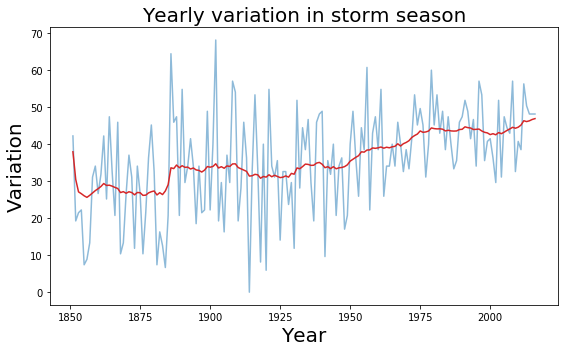

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['mad'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

XXX some words on eta

In short, we have some evidence that the variation of the empirical storm season is not changing in time.  

Nonetheless, there are other ways to address the idea of Dr. Hassenzahl's question.  Next, we investigate whether or not the proportion of storms occuring outside of the official storm season is changing in time.

-0.31131526487170613
[-0.21897858 -0.11316261  0.09488896  0.30519199  0.4237669 ]


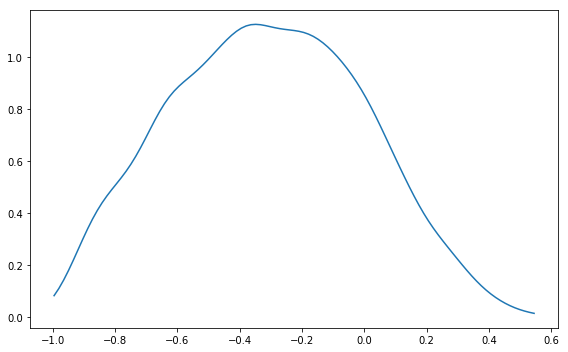

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()  
bp.density(posterior['phi'])
plt.tight_layout()
print(posterior['phi'].mean())
print(np.percentile(posterior['eta'], [2.5, 10, 50, 90, 97.5]))

# Annual Percentage of Storms Outside Official Storm Season Changing?

The official storm season is between June 01 and November 30.  In some years, all the storms fall within the official storm season.  In other years, there are a few storms that fall outside the official storm season.  Here, we consider the yearly percentage of storms that occur outside of the official storm season.  This percentage is calculated for each year as follows.  Divide the number of storms that fall outside the official storm season in a given year by the number storms that occured in that year and then multiple my 100.  If this yearly percentage were to change over time, we might believe that the empirical storm season were changing.

We first calculate the percentage of storms occuring outside of the official storm season for each year.

In [150]:
def outside_SS(df):
    y = df['year'].values[0]
    early = np.sum(df['date'] < datetime.datetime(y, 6, 1))
    late = np.sum(df['date'] > datetime.datetime(y, 10, 30))
    return 100 * (early + late) / df['year'].shape[0]

sdf['prop'] = df.groupby('year', as_index=False).apply(outside_SS)

Plotting these percentages over time shows that there were many years before 1975 where there were 0 storms outside of the storm season.  From about 1975 forward, there appears to be no years where no storms occured outside of the official storm season.  In no years were all the storms outside of the official storm season.

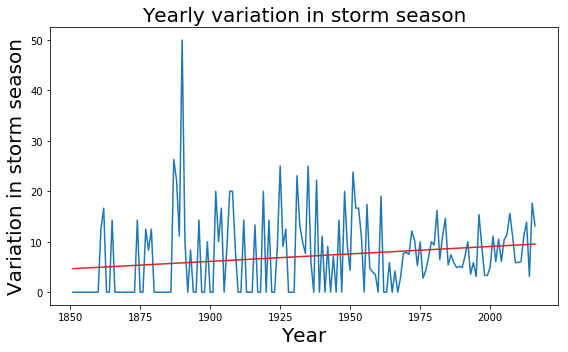

In [131]:
reg = sm.OLS(sdf['prop'], sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], sdf['prop'])
bp.line(sdf['year'], reg.fittedvalues, color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [126]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   prop   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     5.726
Date:                Tue, 26 Jun 2018   Prob (F-statistic):             0.0178
Time:                        15:42:54   Log-Likelihood:                -571.82
No. Observations:                 166   AIC:                             1148.
Df Residuals:                     164   BIC:                             1154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.0613     23.895     -2.095      0.0

We analyze these percentages using the same local linear trend model as above.    If any of the slope-like parameters $\nu_t$ parameters are different from zero, we'll have found some evidence in a changing proportion of storms occuring outside of the official storm season.

In [151]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': sdf['prop']
}
stfit = stmod.sampling(data=sdata) 
posterior = stfit.extract() 

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [152]:
stan_utility.check_treedepth(stfit, max_depth=20)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)
stan_utility.check_rhat(stfit)
stan_utility.check_n_eff(stfit)

0 of 4000 iterations saturated the maximum tree depth of 20 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)
Rhat looks reasonable for all parameters
n_eff / iter looks reasonable for all parameters


-0.3282980785326936
[-0.24700167 -0.13973846  0.05811298  0.25891349  0.3649025 ]


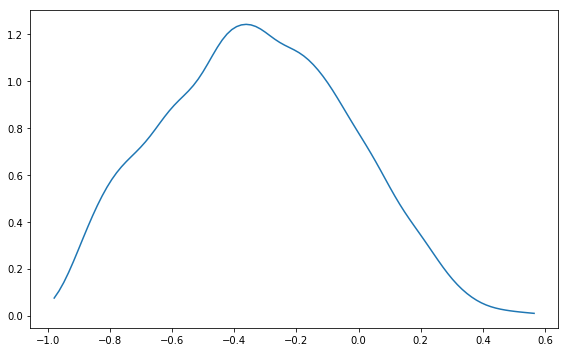

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()  
bp.density(posterior['phi'])
plt.tight_layout()
print(posterior['phi'].mean())
print(np.percentile(posterior['eta'], [2.5, 10, 50, 90, 97.5]))

The model estimates are drawn in red and are superimposed over the light blue observations.

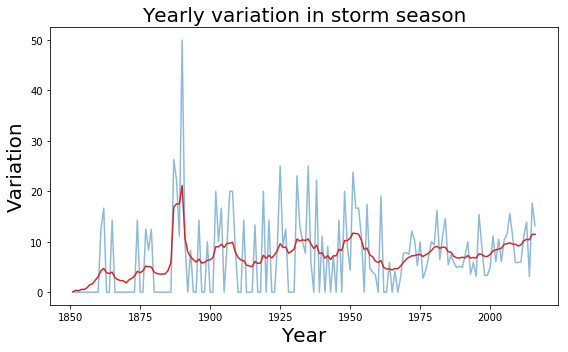

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], sdf['prop'], alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')                  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

It doesn't appear that the percentage of storms occuring outside of the official storm season is changing over time.

Last, we analyze the stationarity of the empirical storm season.

# Is the Distribution of the Empirical Storm Season Stationary?

Consider the average density [histogram](#average_density) above, where the empirical storm season was averaged over all the years for which we have data.  Let's refer to this histogram as the average storm season.  If the empirical storm season was un-changing over time, then this average storm season would represent the stationary distribution from which each year's storm season was randomly drawn.  If such a stationary storm season producing distribution exists, then no year's storm season in our data set should be too different from the average storm season.

To evaluate the stationarity of the storm season, we compute such a histogram for each year's empirical storm season separately.  For instance, consider the [histogram of the storms from 2005](#2005_density).  Now imagine we overlayed the average storm season histogram with the histogram from the 2005 storm season.  We calculate the maximal, absolute difference between these two histograms.  In fact, this is just the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (KS) statistic, for each year's storm season relative to the average storm season.

We walk through each step of the calculations involved.  First, we calculate the average storm season.

In [155]:
hist, bins = np.histogram(df['cnum_dates'], 
                          bins=df['cnum_dates'].nunique(), density=True)
cdf = np.cumsum(hist)
ecdf = cdf/cdf[-1]

Next, we'll replicate this calculation for each year in our data set.

In [156]:
ks = []
for year in np.nditer(df['date'].dt.year.unique()):
    h, _ = np.histogram(df['cnum_dates'][df['date'].dt.year == year], 
                        bins=df['cnum_dates'].nunique(), density=True)
    bcdf = np.cumsum(h)
    ks.append(np.max(np.abs(ecdf - bcdf/bcdf[-1])))
KS = np.array(ks)*100

When we put the inappropriate least squares line through these data, it appears to have a negative slope.  We remind the reader that the yearly KS statistics appear in absolute value.  Hence, a (possible) negative slope is not as indicative as the word negative connotes.  Here, any slope, positive or negative, will simply suggest a non-stationary storm season.

I stand by the inappropriateness of any least squares solution.  I only present it here as a reminder, that which the eye wants to see is not necessarily statistically so, even if one produces a p-value to back up their claim.

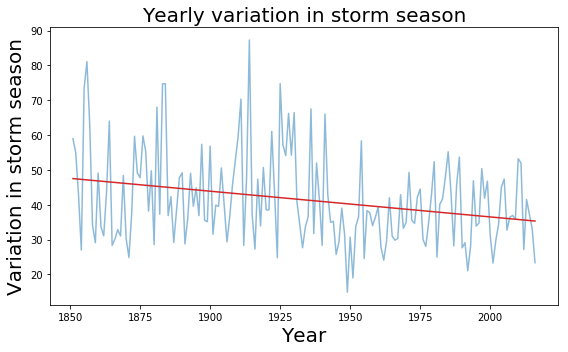

In [39]:
reg = sm.OLS(KS, sm.tools.add_constant(sdf['year'])).fit()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()
bp.curve(sdf['year'], KS, alpha=0.5)
bp.line(sdf['year'], reg.fittedvalues, color='tab:red')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Variation in storm season', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

In [40]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     12.65
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           0.000491
Time:                        21:40:33   Log-Likelihood:                -657.90
No. Observations:                 166   AIC:                             1320.
Df Residuals:                     164   BIC:                             1326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.1344     40.135      4.588      0.0

In [161]:
sdata = {                                                                            
    'T': sdf.shape[0],                                                               
    'y': KS
}
stfit = stmod.sampling(data=sdata, control={'adapt_delta': .925}) 
posterior = stfit.extract()

/Users/ez/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [162]:
stan_utility.check_treedepth(stfit)
stan_utility.check_energy(stfit)
stan_utility.check_div(stfit)
stan_utility.check_rhat(stfit)
stan_utility.check_n_eff(stfit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)
Rhat looks reasonable for all parameters
n_eff / iter looks reasonable for all parameters


The state space model smoothes out the yearly KS statistics.

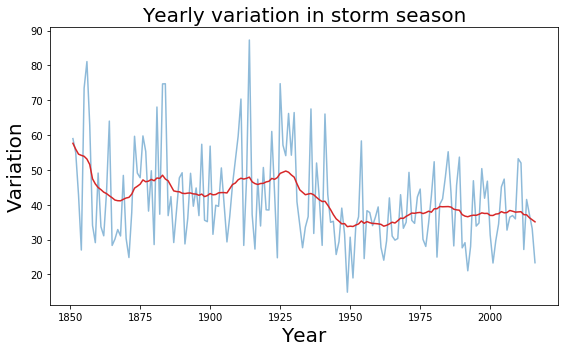

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()                                                                         
bp.curve(sdf['year'], KS, alpha=0.5)                                                   
bp.curve(sdf['year'], posterior['y_pred'].mean(0), color='tab:red')  
plt.ylabel('Variation', fontsize=20)                                                              
plt.xlabel('Year', fontsize=20)
plt.title('Yearly variation in storm season', fontsize=20)
plt.tight_layout()

The state space model accounts for any correlations across time.  Once we account for any such correlations, we see that the slope-like estimates are quite close to zero.

-0.18245792694057655
[-0.45232679 -0.31802784 -0.10161277  0.11427425  0.23868881]


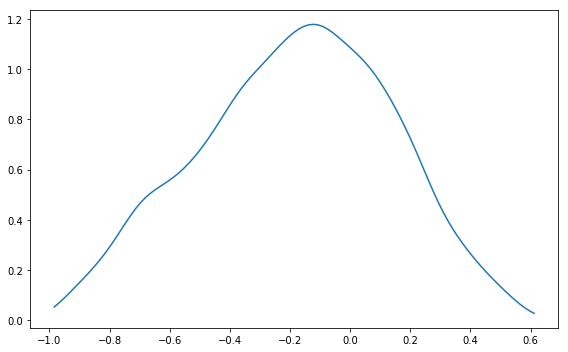

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.cla()  
bp.density(posterior['phi'])
plt.tight_layout()
print(posterior['phi'].mean())
print(np.percentile(posterior['eta'], [2.5, 10, 50, 90, 97.5]))

We find little evidence that the empirical storm season is non-stationary, since no slope like estimates have a credible interval that excludes 0.

# Conclusion

This blog post analyzed the variation of the empirical storm season in two different ways.  First, we considered the MAD estimates of the variation of the empirical storm season.  Second, we analyzed the percentage of storms that occured outside of the official storm season.  Neither of these analyses found evidence of significant changes in the variation of the empirical storm season.  

The last analysis considered the stationarity of the empirical storm season by investigating the slope of the yearly maximal discrepancy between the average storm season and each year's storm season.  Here, we calculated the KS statistic over time.  Unlike the first two studies, the KS statistic will identify any changes in distribution, not just the center or variation.  Yet, even with the yearly KS statistics, we still didn't find any significant changes in the empirical storm season.

A strong word of caution is in order.  None of the work here said anything about the [intensity of storms](https://www.ncdc.noaa.gov/news/tropical-cyclone-%E2%80%9Cmaximum-intensity%E2%80%9D-shifting-toward-poles), nor the [speed of storms](https://www.ncei.noaa.gov/news/tropical-cyclone-slowdown).  XXX

# Acknowledgments

This blog post would not have happened without the great minds of Dave Hassenzahl, Ann Bykerk-Kauffman, and the Department of Geological and Environmental Sciences.  Rachel Hensler and Robin Donatello provided excellent feedback.  And of course, the communities of Python, Stan, and NOAA's National Hurricane Center. 

# References

B. Carpenter, A. Gelman, M. D. Hoffman, D. Lee, B. Goodrich, M. Betancourt, M. Brubaker, J. Guo, P. Li, and A. Riddell. Stan: A probabilistic programming language. Journal of statistical software, 76(1), 2017.

J. Durbin and S. J. Koopman. Time Series Analysis by State Space Methods. Oxford University Press, 2 edition, 2012.